# NOAA Historical Weather Station Data
https://registry.opendata.aws/noaa-isd/

The Integrated Surface Database (ISD) from the United States National Oceanic and Atmospheric Administration (NOAA) consists of global hourly and synoptic observations compiled from numerous sources into a gzipped fixed width format. The data format is described [here](https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf). They also have conveniently converted all of this gzipped, fixed-width data into csv files and host it on an open S3 bucket (`arn:aws:s3:::noaa-global-hourly-pds`). You can [browse the bucket here](https://noaa-global-hourly-pds.s3.amazonaws.com/index.html). The data is also on this [ftp site](https://www1.ncdc.noaa.gov/pub/data/noaa/). This site contains other useful files as well like a [csv file with all the station IDs, locations, and record date ranges](https://www1.ncdc.noaa.gov/pub/data/noaa/isd-history.csv).

In this notebook I will explore the data source by extracting the temperature and dew point data recorded at Centennial Airport in Colorado during 2021.

First, download the csv with station metadata.

In [1]:
!wget https://noaa-isd-pds.s3.amazonaws.com/isd-history.csv -O isd-stations.csv

--2022-06-29 03:26:20--  https://noaa-isd-pds.s3.amazonaws.com/isd-history.csv
Resolving noaa-isd-pds.s3.amazonaws.com (noaa-isd-pds.s3.amazonaws.com)... 52.216.179.139
Connecting to noaa-isd-pds.s3.amazonaws.com (noaa-isd-pds.s3.amazonaws.com)|52.216.179.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2902758 (2.8M) [binary/octet-stream]
Saving to: ‘isd-stations.csv’

isd-stations.csv    100%[===================>]   2.77M  13.4MB/s    in 0.2s    

2022-06-29 03:26:21 (13.4 MB/s) - ‘isd-stations.csv’ saved [2902758/2902758]



Read in the data from the csv, while parsing the correct data types, and merging the `USAF` and `WBAN` together for a single, combined ID

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

isd_stations = (pd.read_csv('isd-stations.csv',
                            parse_dates=['BEGIN', 'END'], 
                            dtype={'USAF': str, 'WBAN': str}
                            )
                .assign(station_id=lambda df_: df_['USAF'] + df_['WBAN'])
)

isd_stations.info()
isd_stations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29615 entries, 0 to 29614
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   USAF          29615 non-null  object        
 1   WBAN          29615 non-null  object        
 2   STATION NAME  28825 non-null  object        
 3   CTRY          28720 non-null  object        
 4   STATE         6622 non-null   object        
 5   ICAO          10803 non-null  object        
 6   LAT           28429 non-null  float64       
 7   LON           28428 non-null  float64       
 8   ELEV(M)       28325 non-null  float64       
 9   BEGIN         29615 non-null  datetime64[ns]
 10  END           29615 non-null  datetime64[ns]
 11  station_id    29615 non-null  object        
dtypes: datetime64[ns](2), float64(3), object(7)
memory usage: 2.7+ MB


,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,station_id
0,007018,99999,WXPOD 7018,NaN,NaN,NaN,0.00,0.000,7018.0,2011-03-09,2013-07-30,00701899999
1,007026,99999,WXPOD 7026,AF,NaN,NaN,0.00,0.000,7026.0,2012-07-13,2017-08-22,00702699999
2,007070,99999,WXPOD 7070,AF,NaN,NaN,0.00,0.000,7070.0,2014-09-23,2015-09-26,00707099999
3,008260,99999,WXPOD8270,NaN,NaN,NaN,0.00,0.000,0.0,2005-01-01,2012-07-31,00826099999
4,008268,99999,WXPOD8278,AF,NaN,NaN,32.95,65.567,1156.7,2010-05-19,2012-03-23,00826899999


Filter the data to all stations in Colorado that have data from 2022 and have the word `AIRPORT` in the name.

In [3]:
(isd_stations[ (isd_stations['STATE']=='CO') & 
               (isd_stations['END'] > '2022') & 
               (isd_stations['STATION NAME'].str.contains('AIRPORT'))
            ]
            .sort_values(by=['END', 'STATION NAME'], ascending=[False, True])
            .head(100)
)

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,station_id
19569,724620,23061,SAN LUIS VALLEY REGIONAL AIRPORT,US,CO,KALS,37.439,-105.862,2297.4,1973-01-01,2022-06-28,72462023061
17465,720539,00165,STEVENS FIELD AIRPORT,US,CO,KPSO,37.283,-107.050,2335.1,2009-10-01,2022-06-28,72053900165
17999,722101,03039,WOLF CREEK PASS AWOS-3 AIRPORT,US,CO,KCPW,37.450,-106.800,3593.9,2006-01-01,2022-06-28,72210103039
17456,720531,00158,BLAKE FIELD AIRPORT,US,CO,KAJZ,38.783,-108.067,1583.1,2012-02-09,2022-06-27,72053100158
17458,720533,00160,BOULDER MUNICIPAL AIRPORT,US,CO,KBDU,40.033,-105.217,1612.1,2010-02-01,2022-06-27,72053300160
19607,724680,94015,BUTTS AAF AIRPORT,US,CO,KFCS,38.678,-104.757,1779.4,1966-09-15,2022-06-27,72468094015
19590,724666,93067,CENTENNIAL AIRPORT,US,CO,KAPA,39.560,-104.848,1789.2,2006-01-01,2022-06-27,72466693067
19655,724767,93069,CORTEZ MUNICIPAL AIRPORT,US,CO,KCEZ,37.307,-108.626,1799.2,2006-01-01,2022-06-27,72476793069
20276,725700,24046,CRAIG-MOFFAT AIRPORT,US,CO,KCAG,40.493,-107.524,1884.9,2006-01-01,2022-06-27,72570024046
20265,725650,03017,DENVER INTERNATIONAL AIRPORT,US,CO,KDEN,39.847,-104.656,1647.2,1994-07-18,2022-06-27,72565003017


I want to get the data for the Centennial Airport, so I will use `station_id = 72466693067`

In [4]:
URL_BASE = 'https://noaa-global-hourly-pds.s3.amazonaws.com'
year = 2021
station_id = '72565003017'
csv_path = f'{URL_BASE}/{year}/{station_id}.csv'

station_data = pd.read_csv(csv_path)
station_data.head()

/tmp/ipykernel_4377/3032895316.py:6: DtypeWarning: Columns (42,43,54,94) have mixed types. Specify dtype option on import or set low_memory=False.
  station_data = pd.read_csv(csv_path)


,STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,...,OD1,OE1,OE2,OE3,RH1,RH2,RH3,WA1,REM,EQD
0,72565003017,2021-01-01T00:00:00,4,39.84657,-104.65623,1647.2,"DENVER INTERNATIONAL AIRPORT, CO US",FM-12,99999,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SYN08072565 32866 63404 10000 21056 38317 4016...,NaN
1,72565003017,2021-01-01T00:53:00,7,39.84657,-104.65623,1647.2,"DENVER INTERNATIONAL AIRPORT, CO US",FM-15,KDEN,V030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET10712/31/20 17:53:03 METAR KDEN 010053Z 340...,NaN
2,72565003017,2021-01-01T01:53:00,7,39.84657,-104.65623,1647.2,"DENVER INTERNATIONAL AIRPORT, CO US",FM-15,KDEN,V030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET10812/31/20 18:53:03 METAR KDEN 010153Z 340...,NaN
3,72565003017,2021-01-01T02:53:00,7,39.84657,-104.65623,1647.2,"DENVER INTERNATIONAL AIRPORT, CO US",FM-15,KDEN,V030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET10612/31/20 19:53:03 METAR KDEN 010253Z 000...,NaN
4,72565003017,2021-01-01T03:00:00,4,39.84657,-104.65623,1647.2,"DENVER INTERNATIONAL AIRPORT, CO US",FM-12,99999,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SYN06472565 32966 60000 10000 21078 38343 4018...,NaN


There are a lot of columns. I'm mostly interested in temperature and dew point, but they are in a strange format. According to the data format document, the values include the value in degrees celsius multiplied by 10 followed by a data quality flag separated by a comma. We will need to parse this out. 

In [5]:
station_data[['DATE', 'TMP', 'DEW']].head()

,DATE,TMP,DEW
0,2021-01-01T00:00:00,"+0000,1","-0056,1"
1,2021-01-01T00:53:00,"+0000,5","-0067,5"
2,2021-01-01T01:53:00,"-0006,5","-0061,5"
3,2021-01-01T02:53:00,"+0000,5","-0078,5"
4,2021-01-01T03:00:00,"+0000,1","-0078,1"


In [9]:
station_data[['temperature_degC', 'temperature_QC']] = station_data['TMP'].str.split(',', expand=True)
station_data[['dew_point_degC', 'dew_point_QC']] = station_data['DEW'].str.split(',', expand=True)

station_data = (station_data
                  .astype({'temperature_degC': float, 'dew_point_degC': float})
                  .assign(temperature_degC=lambda df_: (df_['temperature_degC'] / 10).replace(999.9, np.nan),
                          dew_point_degC=lambda df_: (df_['dew_point_degC'] / 10).replace(999.9, np.nan),
                  )
            )

In [10]:
station_data[['STATION', 'DATE', 'TMP', 'DEW', 'temperature_degC', 'dew_point_degC', 'temperature_QC', 'dew_point_QC']].head()

,STATION,DATE,TMP,DEW,temperature_degC,dew_point_degC,temperature_QC,dew_point_QC
0,72565003017,2021-01-01T00:00:00,"+0000,1","-0056,1",0.0,-5.6,1,1
1,72565003017,2021-01-01T00:53:00,"+0000,5","-0067,5",0.0,-6.7,5,5
2,72565003017,2021-01-01T01:53:00,"-0006,5","-0061,5",-0.6,-6.1,5,5
3,72565003017,2021-01-01T02:53:00,"+0000,5","-0078,5",0.0,-7.8,5,5
4,72565003017,2021-01-01T03:00:00,"+0000,1","-0078,1",0.0,-7.8,1,1


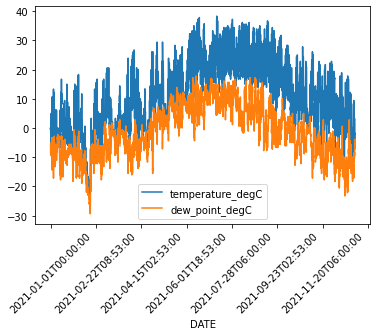

In [11]:
station_data.set_index('DATE')[['temperature_degC', 'dew_point_degC']].plot()
plt.xticks(rotation=45);

# Open Weather API

The NOAA data has historical weather for the weather stations, but it updates with a lag of a few days. I'd like to have more up to date weather data I can pull hourly. For that, I can use the [Open Weather API](https://openweathermap.org/).


In [17]:
import pandas as pd
from dotenv import load_dotenv
import os
import requests
load_dotenv()
OWM_KEY = os.getenv('OWM_KEY')

In [18]:
url = 'https://api.openweathermap.org/data/2.5/weather?'

params = {'appid': OWM_KEY,
          'lat': 39.847,
          'lon': -104.656,
          'units': 'metric'}

r = requests.get(url, params)
r

<Response [200]>

In [19]:
r.json()

{'coord': {'lon': -104.656, 'lat': 39.847},
 'weather': [{'id': 801,
   'main': 'Clouds',
   'description': 'few clouds',
   'icon': '02n'}],
 'base': 'stations',
 'main': {'temp': 25.49,
  'feels_like': 24.67,
  'temp_min': 23.12,
  'temp_max': 27.46,
  'pressure': 1022,
  'humidity': 22},
 'visibility': 10000,
 'wind': {'speed': 7.2, 'deg': 190},
 'clouds': {'all': 20},
 'dt': 1656473325,
 'sys': {'type': 1,
  'id': 3801,
  'country': 'US',
  'sunrise': 1656415956,
  'sunset': 1656469859},
 'timezone': -21600,
 'id': 5412777,
 'name': 'Barr Lake',
 'cod': 200}

In [20]:
df = (pd.DataFrame(r.json()['main'], index=[0])
    .assign(timestamp=pd.to_datetime(r.json()['dt'], unit='s').tz_localize('UTC'),
           **r.json()['coord']
           )
)

df.columns

Index(['temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'timestamp', 'lon', 'lat'],
      dtype='object')

In [21]:
pd.to_datetime(r.json()['dt'], unit='s').tz_localize('UTC')

Timestamp('2022-06-29 03:28:45+0000', tz='UTC')